In [1]:
%matplotlib inline
import numpy as np
import pyfftw
try:
    from nbodykit.lab import *
    from nbodykit import setup_logging, style
except:
    print('no nbodykit')
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from abacusnbody.data.compaso_halo_catalog import CompaSOHaloCatalog
import warnings
warnings.filterwarnings("ignore")
import pickle
from scipy.stats import poisson
from Corrfunc.theory import *
from astropy.cosmology import FlatLambdaCDM
from scipy.ndimage import convolve
from scipy.interpolate import interp1d
from scipy.stats import norm
import sys
sys.path.append('../')
sys.path.append('../../')

In [2]:
from cosmology_functions import *
from run_matrixA import *
from save_matrixA_nooverlap import load_matrixA_slab

In [3]:
# parameters about the sim
boxsize = 2000.
k0 = 2*np.pi/boxsize
N0 = 6912
N = 1728
Nfiles = 34

In [4]:
z = 0.5
Rf = 2 # Gaussian smoothing
Nmesh = 400
interp_method = 'cic'

In [19]:
use_nabla2d1 = True
# delta1 bins
bin_edges_d1 = np.linspace(-4, 5, 40+1)
nbins_d1 = len(bin_edges_d1)-1
# nabla2d1 bins
nbins_nabla2d1 = 1
# saved to which folder
folder = 'matrixA'
if use_nabla2d1:
    bin_edges_nabla2d1_percentile = np.array([0, 5, 35, 65, 95, 100])
    nbins_nabla2d1 = len(bin_edges_nabla2d1_percentile)-1
    folder += '_nabla2d1'

In [20]:
path = '/mnt/store2/xwu/AbacusSummit/base_c000_ph006/z%s_tilde_operators_nbody/Rf%.3g/' % (str(z), Rf) + folder
outpath = path+'/nooverlap'

In [4]:
# def load_matrixA_all(path, Nmesh, interp_method, remove_overlaps=(False, False),
#                   direct_load=True):
#     # we won't have enough memory when using large grids
#     As = [None]*Nfiles
#     ind_slabs = [None]*Nfiles
#     for i in range(Nfiles):
#         As[i], ind_slabs[i] = load_matrixA_slab(i, path, Nmesh, interp_method,
#                                                 remove_overlaps=remove_overlaps, direct_load=direct_load)
#     return As, ind_slabs

In [7]:
def calc_coadded_M(path, Nmesh, interp_method='cic', remove_overlaps=(False, False),
                  direct_load=True, sum_nabla2d1_bins=False, nbins_nabla2d1=None):
    '''
    Load A for each slab and calculate the coadded M.
    '''
    A = load_matrixA_slab(0, path, Nmesh, interp_method,
                          remove_overlaps=remove_overlaps, direct_load=direct_load,
                          sum_nabla2d1_bins=sum_nabla2d1_bins, nbins_nabla2d1=nbins_nabla2d1)[0]
    M_tot = np.dot(A, A.T)
    for i in range(1, Nfiles):
        A = load_matrixA_slab(i, path, Nmesh, interp_method,
                              remove_overlaps=remove_overlaps, direct_load=direct_load,
                              sum_nabla2d1_bins=sum_nabla2d1_bins, nbins_nabla2d1=nbins_nabla2d1)[0]
        M_tot += np.dot(A, A.T)
    return M_tot

In [8]:
def calc_coadded_b(delta_h, path, Nmesh, interp_method='cic', remove_overlaps=(False, False),
                  direct_load=True, sum_nabla2d1_bins=False, nbins_nabla2d1=None):
    '''
    Load A for each slab and calculate the coadded b.
    '''
    A, ind_slab = load_matrixA_slab(0, path, Nmesh, interp_method,
                          remove_overlaps=remove_overlaps, direct_load=direct_load,
                          sum_nabla2d1_bins=sum_nabla2d1_bins, nbins_nabla2d1=nbins_nabla2d1)
    b_tot = np.dot(A, delta_h[ind_slab].reshape(-1)+1.)
    for i in range(1, Nfiles):
        A, ind_slab = load_matrixA_slab(i, path, Nmesh, interp_method,
                            remove_overlaps=remove_overlaps, direct_load=direct_load,
                            sum_nabla2d1_bins=sum_nabla2d1_bins, nbins_nabla2d1=nbins_nabla2d1)
        b_tot += np.dot(A, delta_h[ind_slab].reshape(-1)+1.)
    return b_tot

In [21]:
# centers of the bins
d1_bins = np.zeros(nbins_d1)
for i in range(nbins_d1):
    x = np.linspace(bin_edges_d1[i], bin_edges_d1[i+1], 10)
    d1_bins[i] = np.sum(x*norm.pdf(x))/np.sum(norm.pdf(x))

# pdf of the bins
allbins_pdf = norm.cdf(bin_edges_d1[1:]) - norm.cdf(bin_edges_d1[:-1])
frac_inbins = norm.cdf(bin_edges_d1[-1]) - norm.cdf(bin_edges_d1[0])

if use_nabla2d1:
    d1_bins = d1_bins.reshape(nbins_d1,-1) + np.zeros((nbins_d1, nbins_nabla2d1))
    nabla2d1_bins = np.zeros((nbins_d1, nbins_nabla2d1))
    allbins_pdf = allbins_pdf.reshape(-1,1) * \
        (bin_edges_nabla2d1_percentile[1:] - bin_edges_nabla2d1_percentile[:-1]).reshape(1,-1)

    # load in the delta1 and only use some
    sdelta1 = np.load('/mnt/store2/xwu/AbacusSummit/AbacusSummit_base_c000_ph006/ic/sdelta1_Rf%.3g.npy' % Rf)
    sigma_sdelta1 = np.std(sdelta1)
    sdelta1 = sdelta1.reshape(-1)[::100]/sigma_sdelta1
    # sort the values
    ind = np.argsort(sdelta1)
    sdelta1 = sdelta1[ind]
    arr = np.searchsorted(sdelta1, bin_edges_d1)

    # load in nabla2d1 and only use some
    nabla2d1 = np.load('/mnt/store2/xwu/AbacusSummit/AbacusSummit_base_c000_ph006/ic/nabla2d1_Rf%.3g.npy' % Rf)
    sigma_nabla2d1 = np.std(nabla2d1)
    nabla2d1 = nabla2d1.reshape(-1)[::100]/sigma_nabla2d1
    nabla2d1 = nabla2d1[ind]

    # calculate bin centers
    for m in range(nbins_d1):
        nabla2d1_ = nabla2d1[arr[m]:arr[m+1]]
        bin_edges_nabla2d1 = np.percentile(nabla2d1_, bin_edges_nabla2d1_percentile)
        for n in range(nbins_nabla2d1):
            ii = (nabla2d1_ >= bin_edges_nabla2d1[n]) & (nabla2d1_ < bin_edges_nabla2d1[n+1])
            nabla2d1_bins[m,n] = np.mean(nabla2d1_[ii])

    frac_inbins *= (bin_edges_nabla2d1_percentile[-1] - bin_edges_nabla2d1_percentile[0])/100.
    del sdelta1, nabla2d1, nabla2d1_

# calculate pdf of bins
allbins_pdf /= allbins_pdf.sum()
allbins_pdf = allbins_pdf.reshape(-1)

In [10]:
# load in snapshot
cat = CompaSOHaloCatalog('/mnt/store2/bigsims/AbacusSummit/AbacusSummit_base_c000_ph006/halos/z0.500/',
                         fields=['N', 'x_com', 'r100_com'])

### N > 150 halos

In [24]:
# halo grid
# mass weighted
ii_h = (cat.halos['N'] > 150)
pos_h = cat.halos[ii_h]['x_com']
vals_h = cat.halos[ii_h]['N']
delta_h = ArrayCatalog({'Position': pos_h, 'Value': vals_h}).to_mesh(
    Nmesh=Nmesh, BoxSize=boxsize, resampler=interp_method).compute()
delta_h = delta_h/np.mean(delta_h)-1.
deltak_h = pyfftw.interfaces.numpy_fft.rfftn(delta_h)

In [25]:
P_shot = boxsize**3/ii_h.sum()
kvec, Pk_h = calc_powerspectrum(deltak_h, boxsize)

#### f as a function of delta1 only

In [10]:
remove_overlaps=(False, True)

In [63]:
# As, ind_slabs = load_matrixA_all(path, Nmesh, interp_method, remove_overlaps=remove_overlaps)

In [14]:
# coadd M
# M_tot = calc_coadded_M(path, Nmesh, interp_method, remove_overlaps=remove_overlaps)
# M_tot = calc_coadded_M(As=As)
# M_tot = calc_coadded_M(outpath, Nmesh, interp_method, remove_overlaps=remove_overlaps,
#                   direct_load=True)
M_tot = calc_coadded_M(outpath, Nmesh, interp_method, remove_overlaps=remove_overlaps,
                  direct_load=True, sum_nabla2d1_bins=True, nbins_nabla2d1=nbins_nabla2d1)
M = M_tot

# take care of empty bins
ii_empty = np.diag(M) == 0.
# calculate the reduced matrix
D = np.zeros_like(M)
for i in range(len(M)):
    if ii_empty[i]:
        D[i,i] = 1.
        M[i,i] = 1.
    else:
        D[i,i] = 1/M[i,i]**0.5
M_tot_ = np.dot( D, np.dot(M, D) )
M_ = M_tot_

In [26]:
# coadd b
# b_tot = calc_coadded_b(delta_h, path, Nmesh, interp_method, remove_overlaps=remove_overlaps)
# b_tot = calc_coadded_b(delta_h, As=As, ind_slabs=ind_slabs)
# b_tot = calc_coadded_b(delta_h, outpath, Nmesh, interp_method, remove_overlaps=remove_overlaps,
#                   direct_load=True)
b_tot = calc_coadded_b(delta_h, outpath, Nmesh, interp_method, remove_overlaps=remove_overlaps,
                  direct_load=True, sum_nabla2d1_bins=True, nbins_nabla2d1=nbins_nabla2d1)
b = b_tot

In [19]:
f_delta1 = np.dot(D, np.dot(np.linalg.inv(M_), b/np.diag(M)**0.5))
ncell = Nmesh**3
nparticles = 0.03*N0**3*frac_inbins
f_delta1 *= nparticles/ncell
# check the solution
print((allbins_pdf*f_delta1).sum())

f_delta1_tot = f_delta1

1.0112738147097877


1.012405135715828
1.01103113789095
1.012511879567252
1.0106965220549728
1.012041143918941
1.0125859741973924


(-0.1, 10.0)

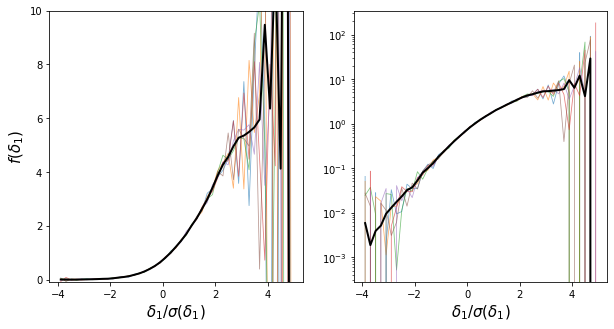

In [20]:
# take a few slabs and calculate a solution for each slab
fig, axes = plt.subplots(figsize=(10,5), nrows=1, ncols=2)

for i in [0, 6, 13, 19, 25, 31]:
    #A, ind_slab = As[i], ind_slabs[i]
    #A, ind_slab = load_matrixA_slab(i, outpath, Nmesh, interp_method,
    #                                remove_overlaps=remove_overlaps, direct_load=True)
    A, ind_slab = load_matrixA_slab(i, outpath, Nmesh, interp_method,
        remove_overlaps=remove_overlaps, direct_load=True, sum_nabla2d1_bins=True, nbins_nabla2d1=nbins_nabla2d1)
    M = np.dot(A, A.T)
    # take care of empty bins
    ii_empty = np.diag(M) == 0.
    # calculate the reduced matrix
    D = np.zeros_like(M)
    for i in range(len(M)):
        if ii_empty[i]:
            D[i,i] = 1.
            M[i,i] = 1.
        else:
            D[i,i] = 1/M[i,i]**0.5
    M_ = np.dot( D, np.dot(M, D) )

    b = np.dot(A, delta_h[ind_slab].reshape(-1)+1.)

    f_delta1 = np.dot(D, np.dot(np.linalg.inv(M_), b/np.diag(M)**0.5))
    ncell = len(ind_slab)*Nmesh**2
    nparticles = 0.03*N0**3*frac_inbins*len(ind_slab)/Nmesh # this is a rough approximation
    f_delta1 *= nparticles/ncell

    # plot each solution
    axes[0].plot(d1_bins, f_delta1, linewidth=0.8, alpha=0.6)
    axes[1].plot(d1_bins, f_delta1, linewidth=0.8, alpha=0.6)

    # check the solution
    print((allbins_pdf*f_delta1).sum())

axes[0].plot(d1_bins, f_delta1_tot, 'k', linewidth=2)
axes[1].plot(d1_bins, f_delta1_tot, 'k', linewidth=2)

axes[0].set_xlabel(r'$\delta_1/\sigma(\delta_1)$', fontsize=15)
axes[1].set_xlabel(r'$\delta_1/\sigma(\delta_1)$', fontsize=15)
axes[0].set_ylabel(r'$f(\delta_1)$', fontsize=15)
axes[1].set_yscale('log')

axes[0].set_ylim(-0.1, 10)

In [21]:
# check how this works...
delta_h_model = np.zeros((Nmesh, Nmesh, Nmesh))
f_delta1 = f_delta1_tot
ncell = Nmesh**3
nparticles = 0.03*N0**3*frac_inbins
for i in range(Nfiles):
    #A, ind_slab = load_matrixA_slab(i, path, Nmesh, interp_method, remove_overlaps=remove_overlaps)
    #A, ind_slab = As[i], ind_slabs[i]
    A, ind_slab = load_matrixA_slab(i, outpath, Nmesh, interp_method,
        remove_overlaps=remove_overlaps, direct_load=True, sum_nabla2d1_bins=True, nbins_nabla2d1=nbins_nabla2d1)
    delta_h_model[ind_slab] += np.dot(f_delta1, A).reshape(-1,Nmesh,Nmesh)
delta_h_model = delta_h_model/(nparticles/ncell) - 1.
print(np.mean(delta_h_model))
deltak_h_model = pyfftw.interfaces.numpy_fft.rfftn(delta_h_model)

0.011220578129189468

In [22]:
kvec, Pk_h_model = calc_powerspectrum(deltak_h_model, boxsize)
Pk_res = calc_powerspectrum(deltak_h-deltak_h_model, boxsize)[1]
Pk_res_h = calc_powerspectrum(deltak_h-deltak_h_model, boxsize, grid2=deltak_h)[1]

Text(0.5, 0, '$k$')

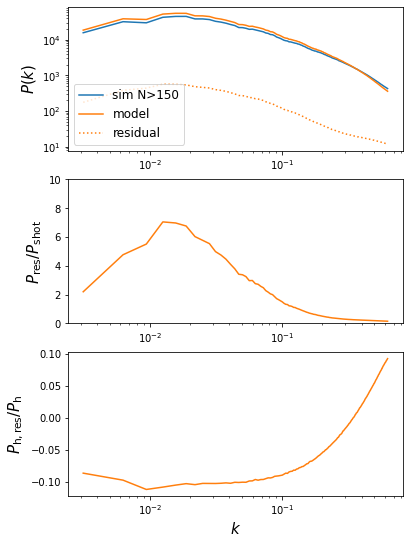

In [28]:
plt.figure(figsize=(6,9))
plt.subplot(311)
plt.loglog(kvec, Pk_h, label='sim N>150')
plt.loglog(kvec, Pk_h_model, label='model')
plt.loglog(kvec, Pk_res, 'tab:orange', linestyle=':', label='residual')
plt.ylabel(r'$P(k)$', fontsize=15)
plt.legend(fontsize=12)
plt.subplot(312)
plt.semilogx(kvec, Pk_res/P_shot, 'tab:orange')
plt.ylim(0, 10)
plt.ylabel(r'$P_{\rm res}/P_{\rm shot}$', fontsize=15)
plt.subplot(313)
plt.semilogx(kvec, Pk_res_h/Pk_h, 'tab:orange')
plt.ylabel(r'$P_{\rm h, res}/P_{\rm h}$', fontsize=15)
plt.xlabel(r'$k$', fontsize=15)

##### examinations of the matrix M

In [15]:
ii_empty

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False])

In [16]:
np.linalg.cond(M_tot), np.linalg.cond(M_tot_)

(20189662.629785024, 836.8572032414583)

In [17]:
np.linalg.eigvals(M_tot_)

array([12.40937506,  6.3135325 ,  4.52749186,  3.49558491,  2.66373065,
        2.00861829,  1.52324318,  1.15880931,  0.89108091,  0.69803567,
        0.55824402,  0.45586761,  0.38082068,  0.32544785,  0.2853224 ,
        0.25745783,  0.23428593,  0.21235271,  0.19131353,  0.17131174,
        0.15308876,  0.13652886,  0.12168258,  0.10848181,  0.0969116 ,
        0.08690762,  0.07757102,  0.06909722,  0.06103027,  0.05358498,
        0.04679187,  0.04063941,  0.03536705,  0.0307485 ,  0.01482855,
        0.01620654,  0.01809747,  0.02045641,  0.02674506,  0.02330778])

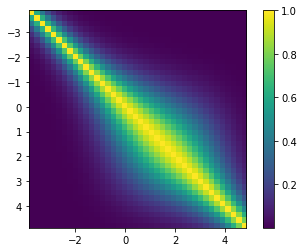

In [18]:
plt.imshow(M_tot_, extent=(d1_bins[0],d1_bins[-1],d1_bins[-1],d1_bins[0]))
plt.colorbar()

#### including nabla2d1

In [22]:
remove_overlaps=(False, True)

In [16]:
# As, ind_slabs = load_matrixA_all(path, Nmesh, interp_method, remove_overlaps=remove_overlaps)

In [23]:
# M_tot = calc_coadded_M(path, Nmesh, interp_method, remove_overlaps=remove_overlaps)
# M_tot = calc_coadded_M(As=As)
M_tot = calc_coadded_M(outpath, Nmesh, interp_method, remove_overlaps=remove_overlaps,
                  direct_load=True)
M = M_tot

# take care of empty bins
ii_empty = np.diag(M) == 0.
# calculate the reduced matrix
D = np.zeros_like(M)
for i in range(len(M)):
    if ii_empty[i]:
        D[i,i] = 1.
        M[i,i] = 1.
    else:
        D[i,i] = 1/M[i,i]**0.5
M_tot_ = np.dot( D, np.dot(M, D) )
M_ = M_tot_

In [18]:
# b_tot = calc_coadded_b(delta_h, path, Nmesh, interp_method, remove_overlaps=remove_overlaps)
# b_tot = calc_coadded_b(delta_h, As=As, ind_slabs=ind_slabs)
b_tot = calc_coadded_b(delta_h, outpath, Nmesh, interp_method, remove_overlaps=remove_overlaps,
                  direct_load=True)
b = b_tot

In [27]:
f_delta1 = np.dot(D, np.dot(np.linalg.inv(M_), b/np.diag(M)**0.5))
ncell = Nmesh**3
nparticles = 0.03*N0**3*frac_inbins
f_delta1 *= nparticles/ncell
# check the solution
print((allbins_pdf*f_delta1).sum())

0.9931111239599918


Text(0, 0.5, '$\\nabla^2\\delta_1/\\sigma(\\nabla^2\\delta_1)$')

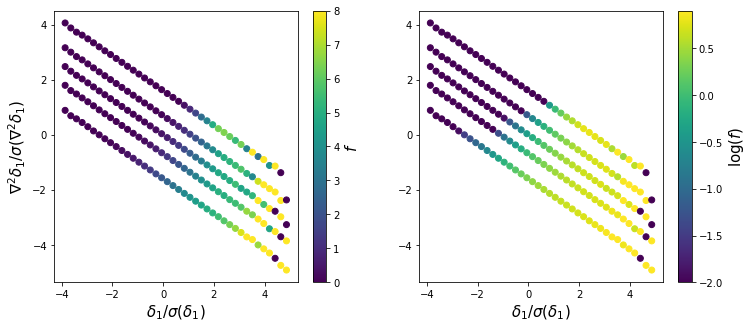

In [28]:
# plot the solution
fig, axes = plt.subplots(figsize=(12,5), nrows=1, ncols=2)

im = axes[0].scatter(d1_bins, nabla2d1_bins, c=f_delta1.clip(0), vmin=0, vmax=8)
cbar = plt.colorbar(im, ax=axes[0])
cbar.set_label(r'$f$', fontsize=15)
im = axes[1].scatter(d1_bins, nabla2d1_bins, c=np.log10(f_delta1.clip(1e-2, 8)))
cbar = plt.colorbar(im, ax=axes[1])
cbar.set_label(r'$\log(f)$', fontsize=15)

axes[0].set_xlabel(r'$\delta_1/\sigma(\delta_1)$', fontsize=15)
axes[1].set_xlabel(r'$\delta_1/\sigma(\delta_1)$', fontsize=15)
axes[0].set_ylabel(r'$\nabla^2\delta_1/\sigma(\nabla^2\delta_1)$', fontsize=15)

In [29]:
# check how this works...
delta_h_model = np.zeros((Nmesh, Nmesh, Nmesh))
for i in range(Nfiles):
    #A, ind_slab = load_matrixA_slab(i, path, Nmesh, interp_method, remove_overlaps=remove_overlaps)
    #A, ind_slab = As[i], ind_slabs[i]
    A, ind_slab = load_matrixA_slab(i, outpath, Nmesh, interp_method,
                                    remove_overlaps=remove_overlaps, direct_load=True)
    delta_h_model[ind_slab] += np.dot(f_delta1, A).reshape(-1,Nmesh,Nmesh)
delta_h_model = delta_h_model/(nparticles/ncell) - 1.
print(np.mean(delta_h_model))
deltak_h_model = pyfftw.interfaces.numpy_fft.rfftn(delta_h_model)

-0.006852897946082674


In [30]:
kvec, Pk_h_model = calc_powerspectrum(deltak_h_model, boxsize)
Pk_res = calc_powerspectrum(deltak_h-deltak_h_model, boxsize)[1]
Pk_res_h = calc_powerspectrum(deltak_h-deltak_h_model, boxsize, grid2=deltak_h)[1]

Text(0.5, 0, '$k$')

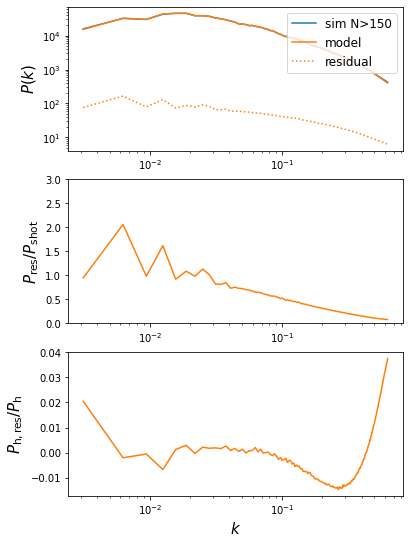

In [31]:
plt.figure(figsize=(6,9))
plt.subplot(311)
plt.loglog(kvec, Pk_h, label='sim N>150')
plt.loglog(kvec, Pk_h_model, label='model')
plt.loglog(kvec, Pk_res, 'tab:orange', linestyle=':', label='residual')
plt.ylabel(r'$P(k)$', fontsize=15)
plt.legend(fontsize=12, loc=1)
plt.subplot(312)
plt.semilogx(kvec, Pk_res/P_shot, 'tab:orange')
plt.ylim(0, 3)
plt.ylabel(r'$P_{\rm res}/P_{\rm shot}$', fontsize=15)
plt.subplot(313)
plt.semilogx(kvec, Pk_res_h/Pk_h, 'tab:orange')
plt.ylabel(r'$P_{\rm h, res}/P_{\rm h}$', fontsize=15)
plt.xlabel(r'$k$', fontsize=15)

##### examinations of the matrix M

In [24]:
ii_empty

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [25]:
np.linalg.cond(M), np.linalg.cond(M_)

(541642993.4383168, 1598.2064617939307)

In [26]:
np.linalg.eigvals(M_)

array([3.77916924e+01, 1.82567770e+01, 1.21312808e+01, 9.00202381e+00,
       7.02183643e+00, 5.63432789e+00, 4.56135241e+00, 3.77329071e+00,
       3.48328789e+00, 3.42244192e+00, 3.08968543e+00, 2.91764780e+00,
       2.75475343e+00, 2.61777916e+00, 2.41468601e+00, 2.30945828e+00,
       2.09958259e+00, 2.04060061e+00, 1.96619250e+00, 1.82341428e+00,
       1.79683195e+00, 1.67519613e+00, 1.63923162e+00, 1.57024824e+00,
       1.53383005e+00, 1.42269389e+00, 1.35913145e+00, 1.30238791e+00,
       1.24975411e+00, 1.22903329e+00, 1.19436825e+00, 1.14186876e+00,
       1.09582482e+00, 1.08182091e+00, 1.05258026e+00, 9.97652748e-01,
       9.59427334e-01, 9.23976583e-01, 9.13213103e-01, 8.71452501e-01,
       8.66328590e-01, 8.18239464e-01, 8.16635318e-01, 7.83361070e-01,
       7.66663806e-01, 7.61379490e-01, 7.33236614e-01, 7.13800881e-01,
       7.06752273e-01, 6.91624292e-01, 6.40842198e-01, 6.51500374e-01,
       6.60247393e-01, 6.35296761e-01, 6.13210463e-01, 6.04925967e-01,
      

### use the density field as a test

In [13]:
delta_h = BigFileMesh(
    '/mnt/store2/xwu/AbacusSummit/base_c000_ph006/z%s_tilde_operators_nbody/deltaz_Nmesh%d_cic.bigfile'
    % (str(z), Nmesh), 'Field').compute()-1.
deltak_h = pyfftw.interfaces.numpy_fft.rfftn(delta_h)

In [14]:
P_shot = boxsize**3/(0.03*N0**3)
kvec, Pk_h = calc_powerspectrum(deltak_h, boxsize)

In [15]:
b_tot = calc_coadded_b(delta_h, outpath, Nmesh, interp_method, remove_overlaps=remove_overlaps,
                  direct_load=True)
b = b_tot

In [16]:
f_delta1 = np.dot(D, np.dot(np.linalg.inv(M_), b/np.diag(M)**0.5))
ncell = Nmesh**3
nparticles = 0.03*N0**3*frac_inbins
f_delta1 *= nparticles/ncell
# check the solution
print((allbins_pdf*f_delta1).sum())

f_delta1_tot = f_delta1

0.9999847672120652


In [17]:
# check how this works...
delta_h_model = np.zeros((Nmesh, Nmesh, Nmesh))
f_delta1 = f_delta1_tot
ncell = Nmesh**3
nparticles = 0.03*N0**3*frac_inbins
for i in range(Nfiles):
    #A, ind_slab = load_matrixA_slab(i, path, Nmesh, interp_method, remove_overlaps=remove_overlaps)
    #A, ind_slab = As[i], ind_slabs[i]
    A, ind_slab = load_matrixA_slab(i, outpath, Nmesh, interp_method,
                                remove_overlaps=remove_overlaps, direct_load=True)
    delta_h_model[ind_slab] += np.dot(f_delta1, A).reshape(-1,Nmesh,Nmesh)
delta_h_model = delta_h_model/(nparticles/ncell) - 1.
print(np.mean(delta_h_model))
deltak_h_model = pyfftw.interfaces.numpy_fft.rfftn(delta_h_model)

-7.929166354451674e-06

In [18]:
kvec, Pk_h_model = calc_powerspectrum(deltak_h_model, boxsize)
Pk_res = calc_powerspectrum(deltak_h-deltak_h_model, boxsize)[1]
Pk_res_h = calc_powerspectrum(deltak_h-deltak_h_model, boxsize, grid2=deltak_h)[1]

Text(0.5, 0, '$k$')

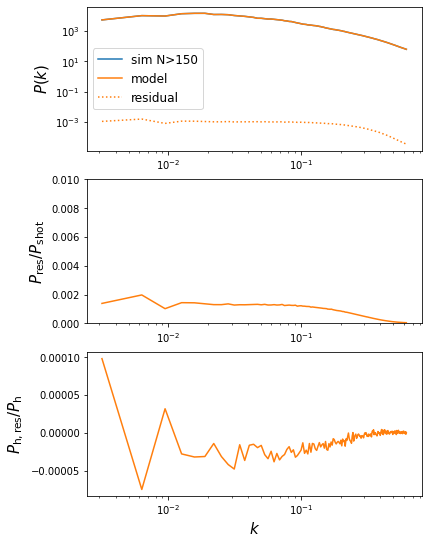

In [19]:
plt.figure(figsize=(6,9))
plt.subplot(311)
plt.loglog(kvec, Pk_h, label='sim N>150')
plt.loglog(kvec, Pk_h_model, label='model')
plt.loglog(kvec, Pk_res, 'tab:orange', linestyle=':', label='residual')
plt.ylabel(r'$P(k)$', fontsize=15)
plt.legend(fontsize=12)
plt.subplot(312)
plt.semilogx(kvec, Pk_res/P_shot, 'tab:orange')
plt.ylim(0, 0.01)
plt.ylabel(r'$P_{\rm res}/P_{\rm shot}$', fontsize=15)
plt.subplot(313)
plt.semilogx(kvec, Pk_res_h/Pk_h, 'tab:orange')
plt.ylabel(r'$P_{\rm h, res}/P_{\rm h}$', fontsize=15)
plt.xlabel(r'$k$', fontsize=15)

In [20]:
# what if I input all ones
delta_h_model = np.zeros((Nmesh, Nmesh, Nmesh))
f_delta1 = f_delta1_tot
ncell = Nmesh**3
nparticles = 0.03*N0**3*frac_inbins
for i in range(Nfiles):
    #A, ind_slab = load_matrixA_slab(i, path, Nmesh, interp_method, remove_overlaps=remove_overlaps)
    #A, ind_slab = As[i], ind_slabs[i]
    A, ind_slab = load_matrixA_slab(i, outpath, Nmesh, interp_method,
                                remove_overlaps=remove_overlaps, direct_load=True)
    delta_h_model[ind_slab] += np.dot(np.ones_like(f_delta1), A).reshape(-1,Nmesh,Nmesh)
delta_h_model = delta_h_model/(nparticles/ncell) - 1.
np.mean(delta_h_model)
deltak_h_model = pyfftw.interfaces.numpy_fft.rfftn(delta_h_model)

7.710403207193581e-06

In [21]:
kvec, Pk_h_model = calc_powerspectrum(deltak_h_model, boxsize)
Pk_res = calc_powerspectrum(deltak_h-deltak_h_model, boxsize)[1]
Pk_res_h = calc_powerspectrum(deltak_h-deltak_h_model, boxsize, grid2=deltak_h)[1]

Text(0.5, 0, '$k$')

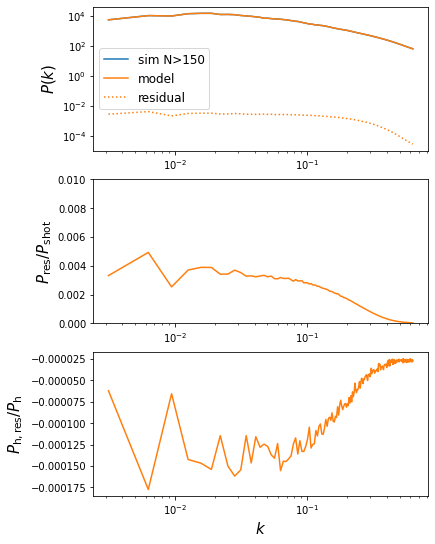

In [22]:
plt.figure(figsize=(6,9))
plt.subplot(311)
plt.loglog(kvec, Pk_h, label='sim N>150')
plt.loglog(kvec, Pk_h_model, label='model')
plt.loglog(kvec, Pk_res, 'tab:orange', linestyle=':', label='residual')
plt.ylabel(r'$P(k)$', fontsize=15)
plt.legend(fontsize=12)
plt.subplot(312)
plt.semilogx(kvec, Pk_res/P_shot, 'tab:orange')
plt.ylim(0, 0.01)
plt.ylabel(r'$P_{\rm res}/P_{\rm shot}$', fontsize=15)
plt.subplot(313)
plt.semilogx(kvec, Pk_res_h/Pk_h, 'tab:orange')
plt.ylabel(r'$P_{\rm h, res}/P_{\rm h}$', fontsize=15)
plt.xlabel(r'$k$', fontsize=15)

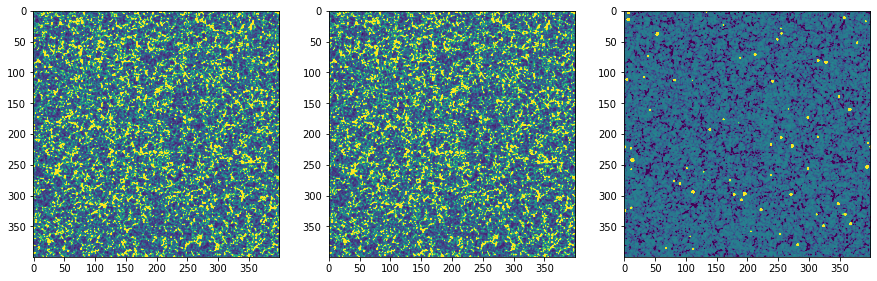

In [23]:
tmp1 = delta_h[:,:,100]
tmp2 = delta_h_model[:,:,100]
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.imshow(tmp1, vmin=-1, vmax=1)
plt.subplot(132)
plt.imshow(tmp2, vmin=-1, vmax=1)
plt.subplot(133)
plt.imshow(tmp1-tmp2, vmin=-1e-4, vmax=1e-4)